# 1. Behavior of k-NN on non-linear data vs. LDA/QDA

Borrowed from [here](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py)

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification, make_blobs
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis

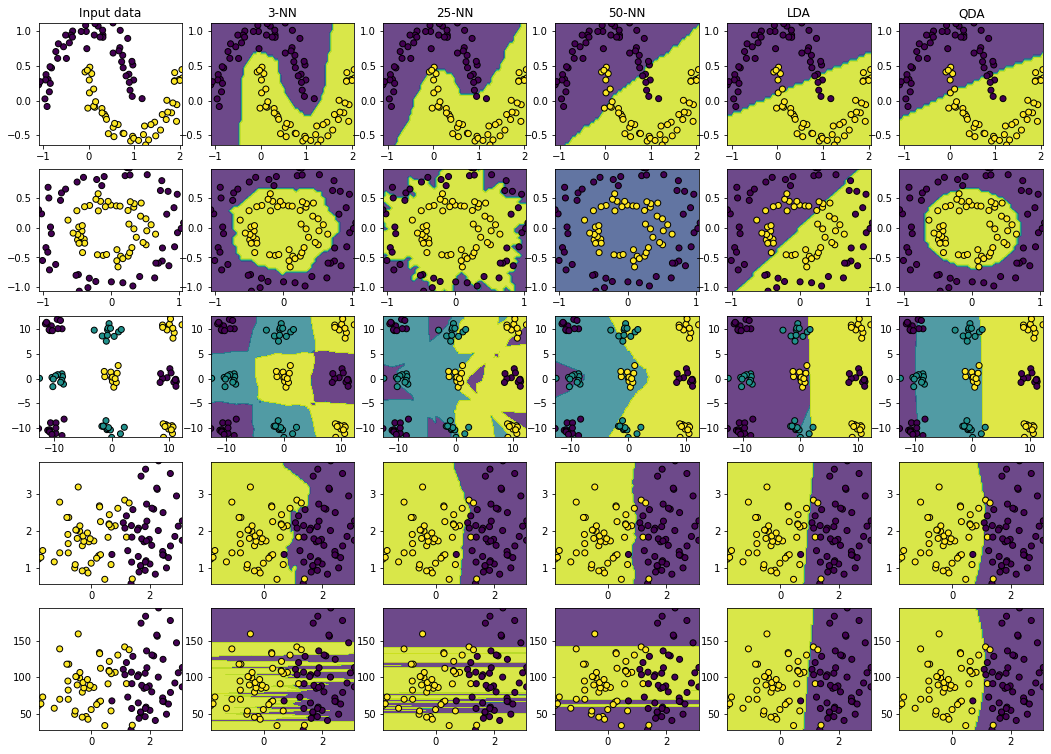

In [14]:
names = ["3-NN", "25-NN", "50-NN", "LDA", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    KNeighborsClassifier(25),
    KNeighborsClassifier(50),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()
]

# linearly separable data
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)


# scale easy data to fool nearest neighbors
X2 =X.copy()
X2[:,1]=50*X[:,1]
linearly_separable2 = (X2, y)

# make checkerboard non-linearly separable data
centers = np.zeros((9, 2))
k=0
for i, a in enumerate([-10, 0, 10]):
    for j, b in enumerate([-10, 0, 10]):
        centers[k,0] = a
        centers[k,1] = b
        k += 1

X3, y3 = make_blobs(n_features=2, centers=centers)
y3 = np.where(y3==2, 0, y3)
y3 = np.where(y3==7, 0, y3)
y3 = np.where(y3==3, 1, y3)
y3 = np.where(y3==5, 1, y3)
y3 = np.where(y3==4, 2, y3)
y3 = np.where(y3==6, 2, y3)
y3 = np.where(y3==8, 2, y3)
checkerboard = (X3,y3)


datasets = [make_moons(noise=0.1, random_state=0),
            make_circles(noise=0.1, factor=0.5, random_state=1),
            checkerboard,
            linearly_separable,
            linearly_separable2
            ]

figure = plt.figure(figsize=(18, 13))

h = .05  # step size in the mesh

i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):

    X, y = ds

    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        plt.title("Input data")
        
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X, y)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, alpha=.8)

        # Plot the training points
        ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        if ds_cnt == 0:
            ax.set_title(name)
        i += 1

# 2. Curse of dimensionality

In this example we will show how pair-wise distances change as we increase the dimensionality

Data is generated as a mixture of Gaussians with the `make_blobs` function from `scikit-learn` and instead of focusing on classifying this
data we will look at the distributions of pair-wise distances as we increase dimensions.


In [50]:
import pandas as pd
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler

sns.set(rc={'figure.figsize':(11.7,8.27)})

In [56]:
df = pd.DataFrame()

for dim in range(1, 300, 20):
    X,_ = make_blobs(n_samples=1000, n_features=dim)
    X = MinMaxScaler().fit_transform(X)   # scale to range 0-1
    D = np.sqrt(X @ X.T) / dim
    df[dim] = D[np.triu_indices_from(D, k=1)]  # obtain upper triangular values only (D is symmetric)

In [57]:
df2=df.melt(var_name="dim", value_name="pair-wise distances")
df2.head()

,dim,pair-wise distances
0,1,0.366129
1,1,0.345660
2,1,0.329186
3,1,0.197567
4,1,0.205017


<AxesSubplot:xlabel='dim', ylabel='pair-wise distances'>

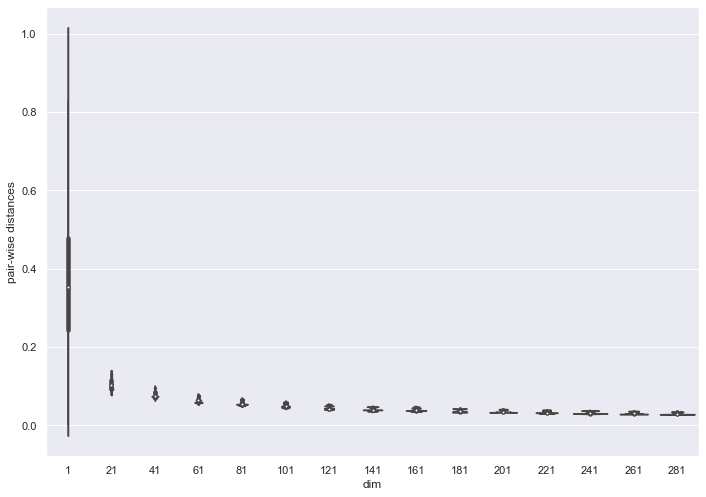

In [58]:
sns.violinplot(x="dim", y="pair-wise distances", data=df2)

# 3. Complexity of finding nearest neighbors

All the complexity of nearest neighbors is pushed to the prediction stage. If we have a large training set, searching for the
nearest neighbors can be slow, this is why several techniques exist to speed up the process. In this code we will show how the
search algorithms affect prediction times. In particular, we will compare a **brute force** approach (just scanning through all examples
sequentially) to using [kd-trees](https://en.wikipedia.org/wiki/K-d_tree) and [ball-trees](). In this comparison, we are going to use the implementations in `scikit-learn`.

In [106]:
from timeit import default_timer as timer
import tqdm
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [112]:
algos = ['brute', 'kd_tree', 'ball_tree']
sizes = np.linspace(4, 6, num=10)
nfeats = [5, 10, 20, 50, 100]

rep = 5
tsize =10 

data = []
for size in tqdm.tqdm([s for s in sizes]):
    for nfeat in nfeats:
        X,y = make_classification(n_samples=int(10**size), n_features=nfeat)
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=tsize)
        for alg in algos:
            knn = KNeighborsClassifier(algorithm=alg, n_neighbors=5, n_jobs=-1)
            knn.fit(X_train, y_train)
            s = 0
            for _ in range(rep):
                begin = timer()
                knn.predict(X_test)
                end = timer()
                s += (end-begin)
            data.append([int(10**size), nfeat, alg, s/rep])

100%|██████████| 10/10 [06:14<00:00, 37.46s/it]


In [113]:
df = pd.DataFrame(data, columns=['size', 'dim', 'algo', 'time'])
df.head()

,size,dim,algo,time
0,10000,5,brute,0.109053
1,10000,5,kd_tree,0.105579
2,10000,5,ball_tree,0.105747
3,10000,10,brute,0.108355
4,10000,10,kd_tree,0.106051


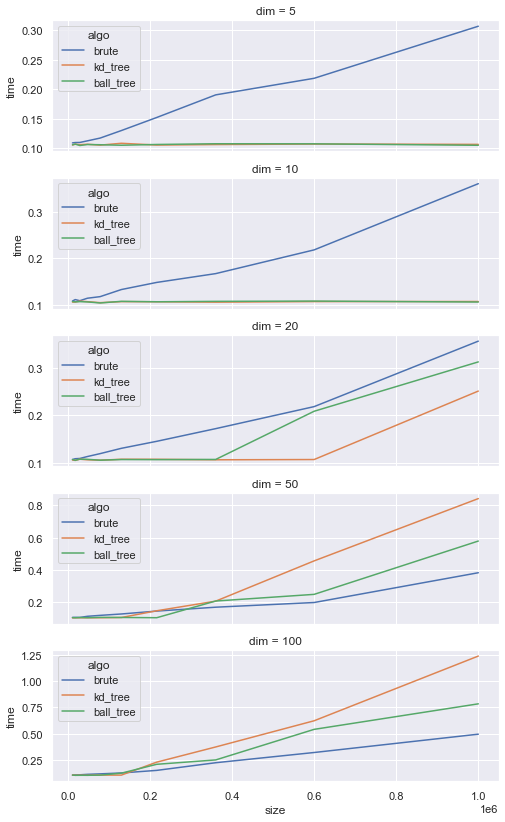

In [114]:
distinct_keys = df['dim'].unique()
fig, axes = plt.subplots(len(distinct_keys), 1, sharex=True, figsize=(8,14))

for i, key in enumerate(distinct_keys):
    this_data = df[df.dim==key]
    sns.lineplot(ax=axes[i], x='size', y='time', hue='algo', data=this_data).set_title(f'dim = {key}')


# 4. Nearest neighbor regression

Heavily based on [sckit-learn's demo](https://scikit-learn.org/stable/auto_examples/neighbors/plot_regression.html)

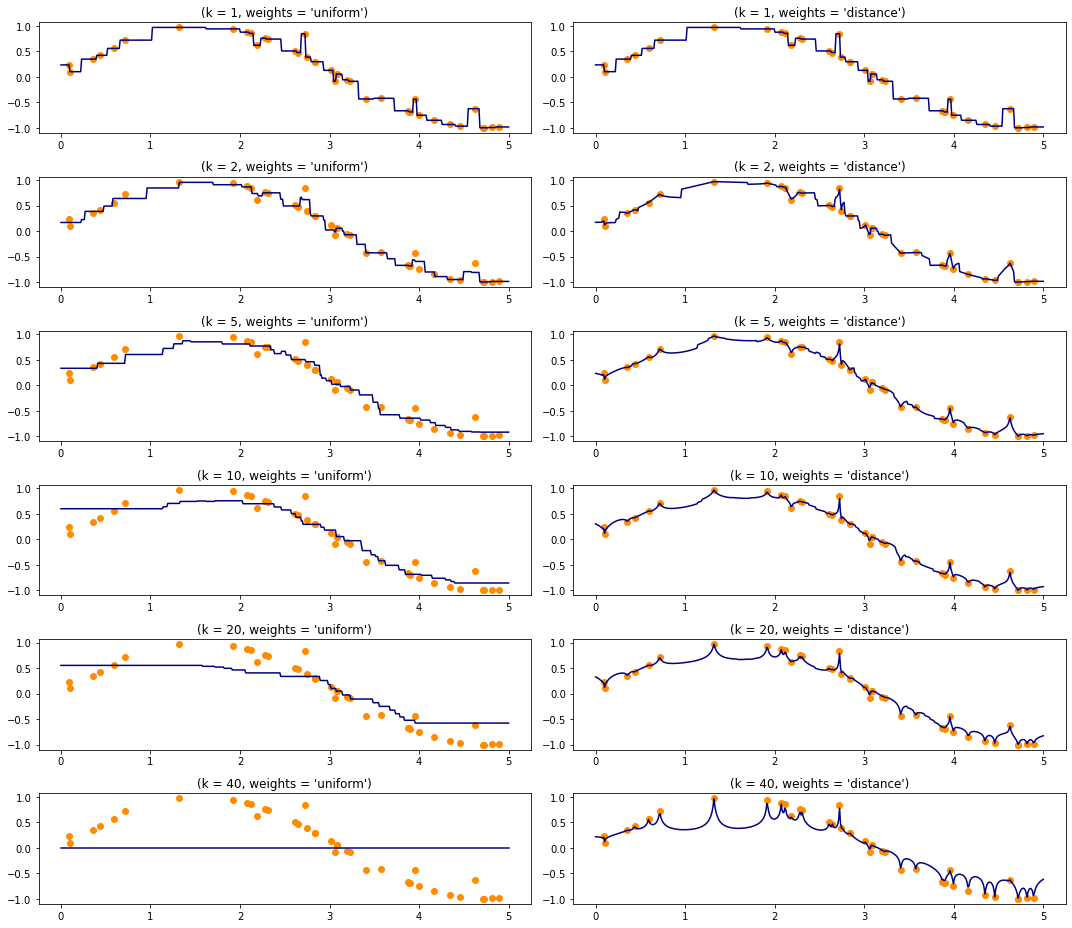

In [13]:
# #############################################################################
# Generate sample data
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors

np.random.seed(0)
X = np.sort(5 * np.random.rand(40, 1), axis=0)
T = np.linspace(0, 5, 500)[:, np.newaxis]
y = np.sin(X).ravel()

# Add noise to targets
y[::5] += 1 * (0.5 - np.random.rand(8))

# #############################################################################
# Fit regression model

plt.figure(figsize=(15, 13))

Ks = [1, 2, 5, 10, 20, 40]

i=1
for n_neighbors in Ks:
    for weights in ['uniform', 'distance']:
        knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
        y_ = knn.fit(X, y).predict(T)

        plt.subplot(len(Ks), 2, i)
        plt.scatter(X, y, color='darkorange', label='data')
        plt.plot(T, y_, color='navy', label='prediction')
        plt.axis('tight')
        plt.title(f"(k = {n_neighbors}, weights = '{weights}')")
        i += 1

plt.tight_layout()
plt.show()